# Attempt to use XGBoost model for forecasting

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('../../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()
print(df_monthly.head())

    DATETIME  CARBON_INTENSITY
0 2009-01-31        578.405242
1 2009-02-28        534.950893
2 2009-03-31        464.442876
3 2009-04-30        408.872917
4 2009-05-31        409.803091


In [82]:
def create_blind_features(df):
    df = df.copy()
    df['month'] = df['DATETIME'].dt.month
    df['year'] = df['DATETIME'].dt.year
    
    # Circular encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df[['DATETIME', 'CARBON_INTENSITY', 'month', 'year', 'month_sin', 'month_cos']]

df_blind = create_blind_features(df_monthly)
df_blind.head()

,DATETIME,CARBON_INTENSITY,month,year,month_sin,month_cos
0,2009-01-31,578.405242,1,2009,0.500000,8.660254e-01
1,2009-02-28,534.950893,2,2009,0.866025,5.000000e-01
2,2009-03-31,464.442876,3,2009,1.000000,6.123234e-17
3,2009-04-30,408.872917,4,2009,0.866025,-5.000000e-01
4,2009-05-31,409.803091,5,2009,0.500000,-8.660254e-01


In [83]:
# Add rolling average features
df_blind['carbon_3m_ma'] = df_blind['CARBON_INTENSITY'].rolling(window=3, min_periods=1).mean()
df_blind['carbon_6m_ma'] = df_blind['CARBON_INTENSITY'].rolling(window=6, min_periods=1).mean()
df_blind['carbon_12m_ma'] = df_blind['CARBON_INTENSITY'].rolling(window=12, min_periods=1).mean()

print("Features with rolling averages:")
print(df_blind.head(15))

Features with rolling averages:
     DATETIME  CARBON_INTENSITY  month  year     month_sin     month_cos  \
0  2009-01-31        578.405242      1  2009  5.000000e-01  8.660254e-01   
1  2009-02-28        534.950893      2  2009  8.660254e-01  5.000000e-01   
2  2009-03-31        464.442876      3  2009  1.000000e+00  6.123234e-17   
3  2009-04-30        408.872917      4  2009  8.660254e-01 -5.000000e-01   
4  2009-05-31        409.803091      5  2009  5.000000e-01 -8.660254e-01   
5  2009-06-30        409.604861      6  2009  1.224647e-16 -1.000000e+00   
6  2009-07-31        389.502688      7  2009 -5.000000e-01 -8.660254e-01   
7  2009-08-31        370.192876      8  2009 -8.660254e-01 -5.000000e-01   
8  2009-09-30        405.683333      9  2009 -1.000000e+00 -1.836970e-16   
9  2009-10-31        464.051075     10  2009 -8.660254e-01  5.000000e-01   
10 2009-11-30        435.417361     11  2009 -5.000000e-01  8.660254e-01   
11 2009-12-31        472.077285     12  2009 -2.449294e-

In [84]:
train = df_blind[df_blind['year'] <= 2022]
print(train.shape)
val   = df_blind[(df_blind['year'] >= 2023) & (df_blind['year'] <= 2024)]
test  = df_blind[df_blind['year'] == 2025]

X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_train = train['CARBON_INTENSITY']
X_val   = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_val   = val['CARBON_INTENSITY']
X_test  = test.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_test  = test['CARBON_INTENSITY']
X_val.head()

(168, 9)


,month,year,month_sin,month_cos,carbon_3m_ma,carbon_6m_ma,carbon_12m_ma
168,1,2023,0.500000,8.660254e-01,160.233669,177.073712,177.091046
169,2,2023,0.866025,5.000000e-01,160.249344,168.072824,180.297023
170,3,2023,1.000000,6.123234e-17,153.653914,159.153805,177.871732
171,4,2023,0.866025,-5.000000e-01,159.242683,159.738176,175.956049
172,5,2023,0.500000,-8.660254e-01,152.992443,156.620894,172.937791


Text(0.5, 1.0, 'XGBoost Validation RMSE')

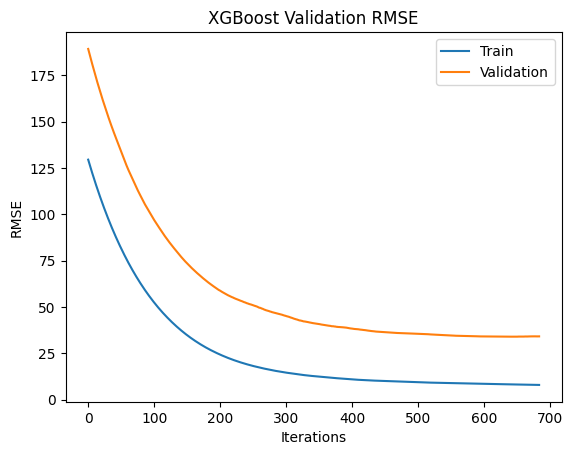

In [85]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=4,
    early_stopping_rounds=50,
    random_state=42
)

# use callback-based early stopping to avoid unsupported keyword argument
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

evals_result = model.evals_result()

plt.plot(evals_result['validation_0']['rmse'], label='Train')

plt.plot(evals_result['validation_1']['rmse'], label='Validation')

plt.legend(['Train', 'Validation'])
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Validation RMSE')

In [86]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE for 2025: {mse:.4f}")

Test MSE for 2025: 1600.7942


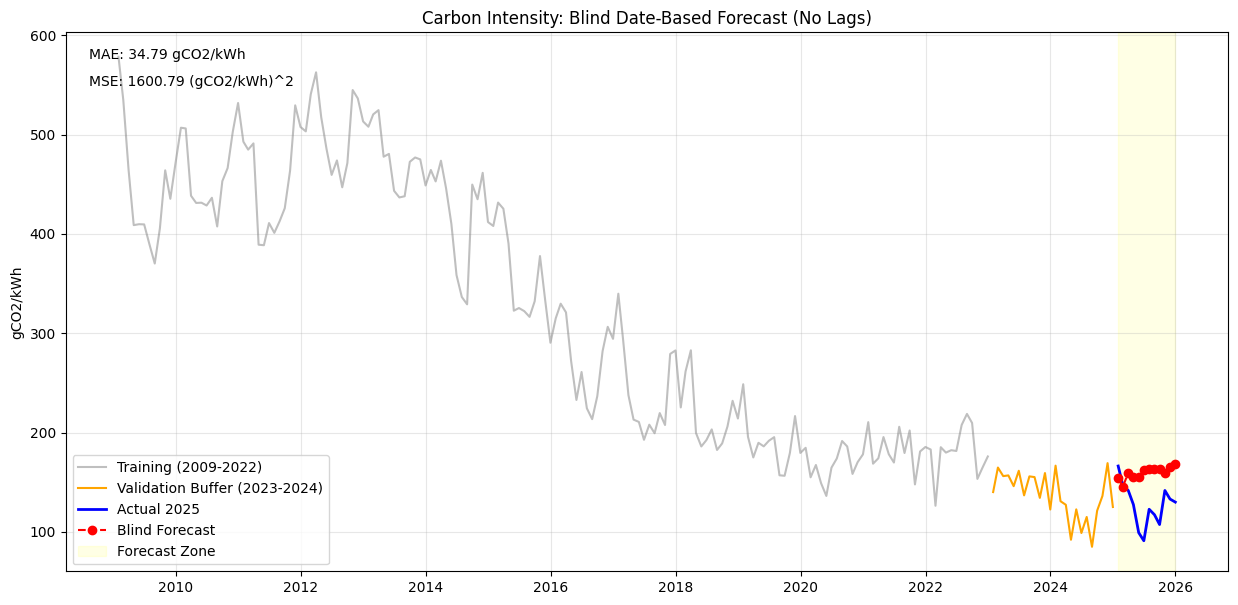

In [87]:
plt.figure(figsize=(15, 7))

# 1. Plot Historical Context
plt.plot(train['DATETIME'], y_train, color='gray', alpha=0.5, label='Training (2009-2022)')
plt.plot(val['DATETIME'], y_val, color='orange', label='Validation Buffer (2023-2024)')

# 2. Plot the Test Year (2025)
plt.plot(test['DATETIME'], y_test, color='blue', linewidth=2, label='Actual 2025')
plt.plot(test['DATETIME'], y_pred, color='red', linestyle='--', marker='o', label='Blind Forecast')

# 3. Formatting
plt.axvspan(test['DATETIME'].min(), test['DATETIME'].max(), color='yellow', alpha=0.1, label='Forecast Zone')
plt.title('Carbon Intensity: Blind Date-Based Forecast (No Lags)')

plt.text(0.02, 0.95, "MAE: {:.2f} gCO2/kWh".format(mae), 
         fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.02, 0.90, "MSE: {:.2f} (gCO2/kWh)^2".format(mse), 
         fontsize=10, color='black', transform=plt.gca().transAxes)

plt.ylabel('gCO2/kWh')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()